##**Import Libraries**

In [1]:
%pip install nltk

In [2]:
import os
import csv
import nltk
import joblib
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

##**Load Dataset**

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/AhlanAlghiff/Mental.ly-Project/refs/heads/Machine-Learning/dataset/Text%20Diagnose%20Dataset.csv")

In [5]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


##**Preprocessing Data & Text**

In [6]:
# Menghapus baris dengan status 'suicidal' berdasarkan kondisi
df = df.drop(df[df['status'] == 'Suicidal'].index)

# Cek apakah status 'suicidal' sudah dihapus
print(df['status'].value_counts())

status
Normal                  16351
Depression              15404
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [7]:
# Remove 10,000 rows from 'Normal' and 'Depression' categories
df_normal = df[df['status'] == 'Normal'].iloc[10000:]
df_depression = df[df['status'] == 'Depression'].iloc[10000:]
df_others = df[~df['status'].isin(['Normal', 'Depression'])]
df = pd.concat([df_normal, df_depression, df_others])
df = df.reset_index(drop=True)

print(df['status'].value_counts())

status
Normal                  6351
Depression              5404
Anxiety                 3888
Bipolar                 2877
Stress                  2669
Personality disorder    1201
Name: count, dtype: int64


In [8]:
df.shape

(22390, 3)

In [9]:
df.isnull().sum()

Unnamed: 0      0
statement     354
status          0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.shape

(22036, 3)

###**Preprocessing Text**

In [12]:
# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

In [14]:
df['processed_statement'] = df['statement'].apply(preprocess_text)

print(df[['statement', 'processed_statement']].head())

                                           statement  \
0                              it passes inspection.   
1  here comes the waiter. see if his hands and na...   
2  well, the waiter looked clean, so i guess it's...   
3              you're forgetting about the bathroom.   
4  i'm going to just hope that the bathroom is cl...   

                          processed_statement  
0                             pass inspection  
1             come waiter see hand nail clean  
2  well waiter looked clean guess 's okay eat  
3                     're forgetting bathroom  
4                'm going hope bathroom clean  


###**Label Encode**

In [15]:
# Memisahkan fitur dan label
X = df['processed_statement']
y = df['status']

In [16]:
# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(y_encoded)

[3 3 3 ... 0 0 0]


In [17]:
len(label_encoder.classes_)

6

In [18]:
# # Mengonversi label menjadi one-hot encoding
# y_final = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# # Cek bentuk label yang sudah diencode
# print(y_final)

##**Tokenizing**

In [19]:
# # Cek Jumlah Kata Unik
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X)
# vocab_size = len(tokenizer.word_index)

# print(f"Total kata unik dalam dataset: {vocab_size}")

In [20]:
# Pakai 5000 batas kata 
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)


In [21]:
# Transformasi teks menjadi sequences
X_seq = tokenizer.texts_to_sequences(X)

In [22]:
# Atur Padding sequences
X_padded = pad_sequences(X_seq, maxlen=100, padding='post')

In [23]:
print(X_padded.shape)

(22036, 100)


##**Split Data**

In [24]:
# Pisahkan data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [25]:
# Cek bentuk data setelah dibagi
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(17628, 100) (4408, 100)
(17628,) (4408,)


##**Modelling & Training**

In [56]:
# Bangun model
model = Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

c:\Users\ahlan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [57]:
model.build((None, 100))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,814 (1.69 MB)

 Trainable params: 443,814 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [59]:
# Latih model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.2933 - loss: 1.6751 - val_accuracy: 0.3117 - val_loss: 1.6533
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.3934 - loss: 1.4631 - val_accuracy: 0.4766 - val_loss: 1.1791
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.4873 - loss: 1.1773 - val_accuracy: 0.4521 - val_loss: 1.1584
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.5154 - loss: 1.1047 - val_accuracy: 0.5057 - val_loss: 1.1080
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 0.5279 - loss: 1.0723 - val_accuracy: 0.5533 - val_loss: 1.0723
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 0.6051 - loss: 0.9564 - val_accuracy: 0.6443 - val_loss: 0.8767
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 61s 111ms/step - accuracy: 0.6784 - loss: 0.7989 - val_accuracy: 0.6590 - val_loss: 0.8269
Epoch 8/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.7009 - loss: 0.72

##**Evaluation**

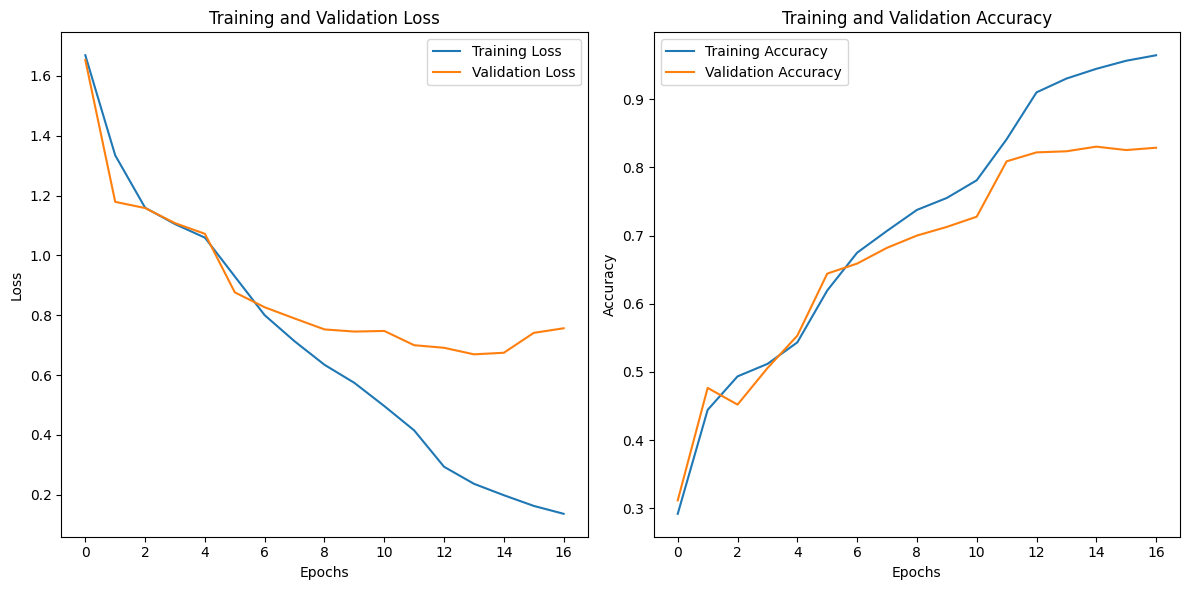

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

history_dict = history.history

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import classification_report

# Prediksi menggunakan model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test

# Menampilkan classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       762
             Bipolar       0.83      0.74      0.78       558
          Depression       0.86      0.80      0.83      1114
              Normal       0.95      0.98      0.96      1272
Personality disorder       0.55      0.64      0.59       210
              Stress       0.62      0.76      0.68       492

            accuracy                           0.82      4408
           macro avg       0.77      0.78      0.77      4408
        weighted avg       0.83      0.82      0.83      4408



##**Save Model**

In [33]:
# dir = "Saved Model"
# os.makedirs(dir, exist_ok=True)

# # Simpan model
# model.save(os.path.join(dir, 'model_text_diagnose.h5'))

# # Simpan tokenizer
# joblib.dump(tokenizer, os.path.join(dir, 'tokenizer.pkl'))

# # Simpan label encoder
# joblib.dump(label_encoder, os.path.join(dir, 'label_encoder.pkl'))

##**Save Model as JSON**

In [62]:
from tensorflow.keras.models import model_from_json

model_in_json = model.to_json()
with open('model1.json', 'w') as json_file:
    json_file.write(model_in_json)

##**Model Predict**

In [4]:
# Load model
model = load_model('model_text_diagnose.h5')

# Memuat tokenizer dan label encoder
tokenizer = joblib.load('tokenizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')


In [ ]:
# Contoh input teks yang ingin diprediksi
input_text = "halo, bagaimana kabarmu?"

# Menggunakan tokenizer untuk mengonversi teks menjadi sequence
input_seq = tokenizer.texts_to_sequences([input_text])

# Padding sequence untuk memastikan panjangnya sesuai dengan input_length model
input_padded = pad_sequences(input_seq, maxlen=100, padding='post')


In [6]:
# Melakukan prediksi
predictions = model.predict(input_padded)

# Mengonversi hasil prediksi menjadi label asli
predicted_label = label_encoder.inverse_transform([predictions.argmax(axis=-1)])

print(f"Prediksi label: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Prediksi label: Normal


c:\Users\ahlan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
